# 鳥の群れ
houdiniでpython SOPノードで実装を予定

参考  
https://qiita.com/piyopiyomaru/items/8c2bf12356303b28fc32


### Boidの基本的アルゴリズム  
- Collision Avoidance: 群れの仲間との衝突を避ける  
- Velocity Matching: 群れの仲間と速度を合わせようとする  
- Flock Centering: 群れの仲間と近づいたままでいようとする  
https://en.m.wikipedia.org/wiki/Boids  
(http://www.cs.toronto.edu/~dt/siggraph97-course/cwr87/)
["Boids Background and Update" by Craig Reynolds]


## 座標と進行方向ベクトル

In [3]:
import numpy as np

width = 25 # フィールド正方形の１辺の長さ。つまりx座標とy座標のとりうる範囲

num_of_birds = 100 # 鳥の数。とりあえず100匹にしておく

pos = np.random.rand(num_of_birds, 2) * (0.6*width - 0.4*width) + 0.4*width # 初期座標をランダム生成する
vec = np.random.rand(num_of_birds, 2) - 0.5 # 初期ベクトルをランダム生成する


## 1. 距離行列を作る

In [7]:
def DISTANCE() :

    global distance # 距離行列の表であるdistanceはグローバルなオブジェクトとして定義しておく
    
    distance = np.zeros([num_of_birds, num_of_birds]) # 空のndarray配列を(鳥の数)*(鳥の数)で作っておく

    for i in range (num_of_birds) :

        for j in range (i+1, num_of_birds) :

            a = pos[i] # 表の横列
            b = pos[j] # 表の縦列

            dist = np.linalg.norm(b-a) # 座標間の距離を計算 #Houdiniでのpointの3次元距離計算にも対応

            distance[i, j] = dist # 距離行列の表のマスに代入

    distance += distance.T # 表の上半分を反転させて、下半分のマスを埋める


## 2. 仲間の場所の平均を求める

In [9]:
# 2.[r_minとr_maxの間の範囲内にいる鳥さんたちの重心を教えてくれる関数]  ※Center of Gravityで重心なのでCG
def GetCG(id, r_min, r_max) :
    
    d = distance[id]

    inRange = np.where((d > r_min) & (d < r_max)) [0]


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation

# ==========パラメーター====================
num_of_birds = 100 # 鳥の数
r_min_c = 0.4 # 近づきたい鳥の範囲の内側
r_max_c = 2.2 # 近づきたい鳥の範囲の外側
r_min_s = 0 # 離れたい鳥の範囲の内側
r_max_s = 0.4 # 離れたい鳥の範囲の外側
r_min_a = 0.4 # 整列したい鳥の範囲の内側
r_max_a = 2.2 # 整列したい鳥の範囲の外側
step = 500 # 試行回数
width = 25 # フィールド正方形の１辺
k1 = 1 # 結合係数
k2 = 25 # 分離係数
k3 = 12 # 整列係数
ts = 25 # 描画スピード
v = 0.12 # 鳥の移動スピード
e = 200 # 反発係数
λ = np.pi / 3 # 鳥の視界の範囲

# ==========座標とベクトルをランダム生成===========

pos = np.random.rand(num_of_birds, 2) * (0.6*width - 0.4*width) + 0.4*width # 初期座標。widthの2/5~3/5の間で出現させたい
vec = np.random.rand(num_of_birds, 2) - 0.5  # 初期ベクトル

# ==================4つの関数====================

# 1.距離行列を作る関数
def DISTANCE() :

    global distance # 距離の表であるdistanceはグローバルなオブジェクトとして定義しておく
    
    distance = np.zeros([num_of_birds, num_of_birds]) # 空のndarray配列を(鳥の数)*(鳥の数)で作っておく

    for i in range (num_of_birds) :

        for j in range (i+1, num_of_birds) :

            a = pos[i]
            b = pos[j]
            dist = np.linalg.norm(b-a)

            distance[i, j] = dist

    distance += distance.T



# 2.r_minとr_maxの間の範囲内にいる鳥さんたちの重心を教えてくれる関数 ※Center of Gravityで重心なのでCG
def GetCG(id, r_min, r_max) :
    
    d = distance[id]

    inRange = np.where((d > r_min) & (d < r_max)) [0]

    if len(inRange) == 0 :
    
        cg = pos[id] + ((np.random.rand(2)* 2 - 1) * 0.0002)
        return cg # ドーナツ内に誰もいなかったら、自分の座標を返す

    else :

        cg = np.mean(pos[inRange], axis = 0)
        return cg #ドーナツ内にあったら、それらの座標の平均を返す



# 3.r_minとr_maxの間の範囲内かつ視界にいる鳥さんのベクトルの平均を教えてくれる関数
def GetVEC(id, r_min, r_max) :
    
    d = distance[id]

    inRange = np.where((d > r_min) & (d < r_max)) [0]

    if len(inRange) == 0 :

        return 0

    else :

        passlist = []
        
        for i in range(len(inRange)) :

            line_vec = pos[inRange][i] - pos[id] # 自分と相手を結んだ直線のベクトル

            θ = np.arctan2(line_vec[1], line_vec[0]) # 自分と相手を結んだ直線のベクトルの角度

            φ = np.arctan2(vec[id][1], vec[id][0]) # 自分の現在の進行方向ベクトルの角度

            if ((φ-λ) < θ) & (θ < (φ+λ)) :

                passlist.append([vec[inRange][i]]) # 視界の範囲内に誰かいたら、その誰かの現在の進行方向ベクトルをpasslistに追加

            else :
                pass

        if len(passlist) == 0 :

            return 0
        
        else :

            pg = np.mean(passlist, axis = 0)
            return pg


# 4.鳥が壁に近づいたら、壁と反対方向に反発させるベクトルを計算する関数
def GetRepulsion(id) :

    # 壁との垂直距離
    left = pos[id][0] - 0 # 左壁との距離
    right = width - pos[id][0] # 右壁との距離
    under = pos[id][1] - 0 # 下壁との距離
    upper = width - pos[id][1] # 上壁との距離

    # 壁との距離が1未満だったら、反対方向に反射させる。ベクトルのデカさは距離の2乗に反比例させて、壁に近ければ近いほど反発力を高める
    if (left < 1) : 
        vec_LEFT = np.array([1,0]) / (left**2) 
    else :
        vec_LEFT = 0

    if (right < 1) : 
        vec_RIGHT = np.array([-1,0]) / (right**2) 
    else :
        vec_RIGHT = 0

    if (under < 1) : 
        vec_UNDER = np.array([0,1]) / (under**2) 
    else :
        vec_UNDER = 0

    if (upper < 1) : 
        vec_UPPER = np.array([0,-1]) / (upper**2) 
    else :
        vec_UPPER = 0

    # 4方面それぞれの反発ベクトルを合成
    vec_R =  vec_LEFT + vec_RIGHT + vec_UNDER + vec_UPPER

    return vec_R



step :  0
step :  1
step :  2
step :  3
step :  4
step :  5
step :  6
step :  7
step :  8
step :  9
step :  10
step :  11
step :  12
step :  13
step :  14
step :  15
step :  16
step :  17
step :  18
step :  19
step :  20
step :  21
step :  22
step :  23
step :  24
step :  25
step :  26
step :  27
step :  28
step :  29
step :  30
step :  31
step :  32
step :  33
step :  34
step :  35
step :  36
step :  37
step :  38
step :  39
step :  40
step :  41
step :  42
step :  43
step :  44
step :  45
step :  46
step :  47
step :  48
step :  49
step :  50
step :  51
step :  52
step :  53
step :  54
step :  55
step :  56
step :  57
step :  58
step :  59
step :  60
step :  61
step :  62
step :  63
step :  64
step :  65
step :  66
step :  67
step :  68
step :  69
step :  70
step :  71
step :  72
step :  73
step :  74
step :  75
step :  76
step :  77
step :  78
step :  79
step :  80
step :  81
step :  82
step :  83
step :  84
step :  85
step :  86
step :  87
step :  88
step :  89
step :  90
step :  9

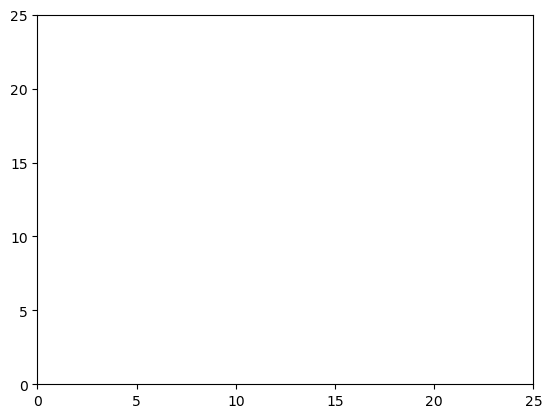

In [11]:
# ====================以下メインで動かすところ====================
# まずはArtistanimationの準備
fig = plt.figure() # 描画領域の確保
img_list = [] # パラパラ漫画の1枚1枚を保存する空の容器(list)


p_pos = np.zeros([num_of_birds, 2]) # 一時的に新しい座標を保存しておくための空の容器(ndarray)
p_vec = np.zeros([num_of_birds, 2]) # 一時的に新しいベクトルを保存しておくための空の容器(ndarray)


for n in range(step) : # パラパラ漫画の枚数(step)分回す

    DISTANCE() # 距離行列を作成。stepを経るごとに距離座標は更新される

    for id in range(num_of_birds) : # 鳥の数(num_of_birds)分回す

        # お近づきになりたい鳥さんたちの座標の平均
        Cohesion = GetCG(id = id, r_min = r_min_c, r_max = r_max_c) - pos[id]
        # 距離をおきたい鳥さんたちの座標の平均
        Separation = GetCG(id = id, r_min = r_min_s, r_max = r_max_s) - pos[id]
        # 一緒に行動したい鳥さんたちのベクトルの平均
        Alignment = GetVEC(id = id, r_min = r_min_a, r_max = r_max_a)
        # 壁に対しての反発ベクトル
        Repulsion = GetRepulsion(id = id)


        # 進むべきベクトルを計算して、絶対値で割って単位ベクトル化
        vec_T = vec[id] + k1* Cohesion - k2* Separation + k3* Alignment + e* Repulsion
        vec_T /= np.linalg.norm(vec_T)


        p_pos[id] = pos[id] + vec_T * v # p_posに新しい座標を保存
        p_vec[id] = vec_T  # p_vecに新しいベクトルを保存


    # pos に p_posを代入して座標更新
    pos = p_pos

    # vec に p_vec を代入してベクトル更新
    vec = p_vec

    # x座標、y座標として登録
    x = pos[:, 0]
    y = pos[:, 1]
    img = plt.scatter(x, y, s = 3,  c= 'blue', marker= '1')
    img_list.append([img])

    print("step : ", n) # カウント用

print("finished.") # カウント用

# ArtistAnimation で描画
anim = ArtistAnimation(
    fig = fig,
    artists = img_list,
    interval = ts,
    blit = True
)

plt.xlim(0, width) # x軸方向の描画範囲
plt.ylim(0, width) # y軸方向の描画範囲
plt.show()